<IPython.core.display.Javascript object>

0
1


[*********************100%%**********************]  1 of 1 completed


Forecasted prices with confidence intervals:
                 Bear       Base       Bull
2024-02-11  16.590317  18.388390  20.335681
2024-02-18  14.991737  17.738990  20.865884
2024-02-25  14.458730  17.892107  21.933695
2024-03-03  14.071046  18.070713  22.910798
2024-03-10  13.515060  17.946385  23.442797
2024-03-17  13.338001  18.228015  24.422646
2024-03-24  12.914773  18.145948  24.908038
2024-03-31  12.631959  18.203619  25.539109
2024-04-07  13.064524  19.196301  27.383031
2024-04-14  12.915886  19.392488  28.174671
2024-04-21  13.232502  20.216879  29.806088
2024-04-28  13.366822  20.783902  31.095158
2024-05-05  12.816539  20.384094  31.074303
2024-05-12  12.088564  19.693756  30.620377
2024-05-19  11.964234  19.858778  31.350541
2024-05-26  11.867571  20.052669  32.116476
2024-06-02  11.563062  19.917764  32.397227
2024-06-09  11.554506  20.223315  33.315737
2024-06-16  11.298479  20.134286  33.645394
2024-06-23  11.147196  20.196850  34.193308
2024-06-30  11.632403  21.27322

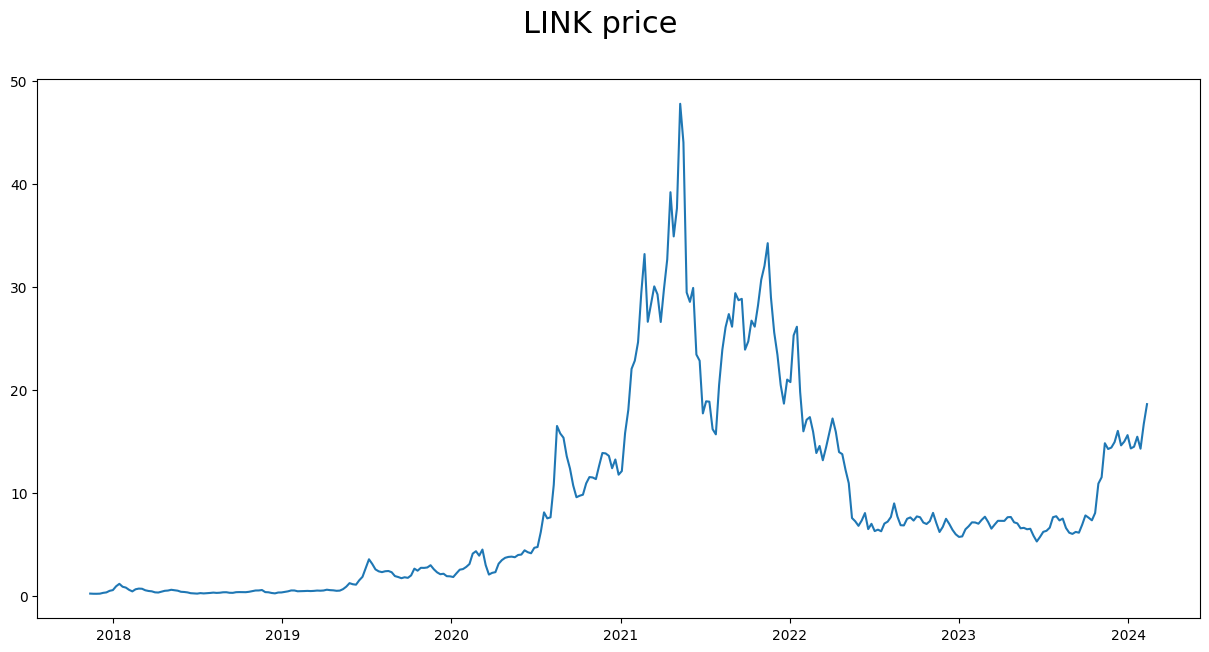

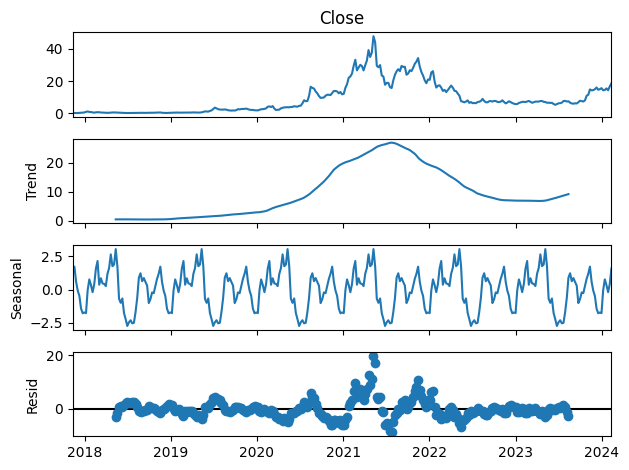

In [20]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 28px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)
for i in range(2):
  print(i)
import yfinance as yf
from scipy import stats, special
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define the ticker symbol and timeframe
symbol = "LINK-USD"
start_date = "2010-01-01"
end_date = "2028-07-01"

# Get the data from Yahoo Finance
ticker_data = yf.download(symbol, start=start_date, end=end_date, interval="1d")

# Extract the daily closing prices
df = ticker_data["Close"]

# Resample to weekly frequency
df_month = df.resample('W').mean()

# Plot monthly prices
fig = plt.figure(figsize=[15, 7])
plt.suptitle('LINK price', fontsize=22)
plt.plot(df_month, '-', label='Monthly')
#plt.legend()
#plt.show()

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(df_month)
fig = decomposition.plot()
#plt.show()

# Perform Box-Cox transformation
df_month_transformed, lmbda = stats.boxcox(df_month)
#print("Lambda:", lmbda)

# Check stationarity
result = sm.tsa.stattools.adfuller(df_month_transformed)
##print("Dickey–Fuller test: p=%f" % result[1])

# Fit SARIMAX model
model = sm.tsa.statespace.SARIMAX(df_month_transformed, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
result = model.fit()

# Forecast next 46 weeks
forecast = result.get_forecast(steps=46)

# Create index for forecasted prices
last_date = df_month.index[-1]
forecast_dates = pd.date_range(last_date, periods=46, freq='W')[:46]

# Confidence intervals
confidence_level = 0.68  # Set the desired confidence level, e.g., 68%
alpha = 1 - confidence_level

confidence_intervals = special.inv_boxcox(forecast.conf_int(alpha=alpha), lmbda)
confidence_intervals_df = pd.DataFrame(confidence_intervals, index=forecast_dates)

# Forecast mean
forecast_mean = special.inv_boxcox(forecast.predicted_mean, lmbda)
# Print forecasted prices
#print("Forecasted prices for the next 46 weeks:")
#print(forecast_mean)

# Forecast mean
forecast_mean = special.inv_boxcox(forecast.predicted_mean, lmbda)

# Combine forecast mean with confidence intervals
forecast_df = pd.DataFrame({
    'Bear': confidence_intervals_df.iloc[:, 0],
    'Base': forecast_mean,
    'Bull': confidence_intervals_df.iloc[:, 1]
}, index=forecast_dates)

# Print the DataFrame
print("Forecasted prices with confidence intervals:")
print(forecast_df)


# Plot forecasted prices with confidence intervals on a log scale using Plotly
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=('LINK in 2024', 'Confidence Intervals'))

# Actual vs Forecasted Prices
fig.add_trace(go.Scatter(x=df_month.index, y=df_month, mode='lines', name='Actual', marker=dict(color='white')))
fig.add_trace(go.Scatter(x=forecast_dates, y=forecast_mean, mode='lines', name='Forecast', marker=dict(color='orange')))
fig.update_yaxes(type='log', row=1, col=1)  # Set y-axis to log scale for the first subplot

# Confidence Intervals
fig.add_trace(go.Scatter(x=forecast_dates, y=confidence_intervals_df.iloc[:, 0], fill='tonexty', mode='lines', name='Bear', marker=dict(color='red')))
fig.add_trace(go.Scatter(x=forecast_dates, y=confidence_intervals_df.iloc[:, 1], fill='tonexty', mode='lines', name='Bull', marker=dict(color='green')))


# ... (your previous code)


# Set layout with a larger plot size and increased font size
fig.update_layout(
    title_text='LINK Price Forecast',
    showlegend=True,
    template='plotly_dark',
    xaxis=dict(title='Time', tickformat='%Y-%m', tickvals=pd.date_range(start=df_month.index[0], end=forecast_dates[-1], freq='Y'),
               tickfont=dict(size=20)),  # Increase font size for x-axis ticks

    yaxis=dict(title='Average Price in $', type='log', tickvals=[1, 5, 10, 20, 30, 50, 100, 1000], tickfont=dict(size=20)),  # Adjust tick values and font size for log scale
    height=1920,  # Set the height of the plot

    font=dict(size=20),  # Set font size for all visible text

)

# Show plot
fig.show()

